# Spatial mapping of cell types across the mouse brain (2/3) - cell2location

In [1]:
! which python3

/users/dyu20/anaconda/cellpymc/bin/python3


In [2]:
! module list

java/8u111        python/2.7.12     anaconda/3-5.2.0  cudnn/7.6.5       
matlab/R2017b     intel/2017.0      cuda/10.2         


In [3]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'


In [4]:
import cell2location

/users/dyu20/anaconda/cellpymc/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: Quadro RTX 6000 (0000:3E:00.0)


In [5]:
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading Visium data <a name="1.-Loading-Visium-data"></a>

In this tutorial, we use a paired Visium and snRNAseq reference dataset of the mouse brain (i.e. generated from adjacent tissue sections). There are two biological replicates and several tissue sections from each brain, totalling 5 10X visium samples. 

First, we need to download and unzip spatial data, as well as download estimated signatures of reference cell types, from our data portal:

In [6]:
# Set paths to data and results used through the document:
sp_data_folder = './data/mouse_brain_visium_wo_cloupe_data/'
results_folder = './results/mouse_brain_snrna/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_55covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

In [7]:
sample_data = pd.read_csv(sp_data_folder +'Visium_mouse.csv')
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Now, let's read the spatial Visium data from the 10X Space Ranger output and examine several QC plots. Here, we load the our Visium mouse brain experiments (i.e. sections) and corresponding histology images into a single anndata object `adata`.

In [8]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder + 'rawdata/'))
    
# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

adata_0 = adata.copy()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


<div class="alert alert-block alert-danger">
<b>Note!</b>
Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.
</div>

In [9]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

In [10]:
str(sample_data['sample_name'][0])

'ST8059048'

In [11]:
sample_data['sample_name']

0    ST8059048
1    ST8059049
2    ST8059050
3    ST8059051
4    ST8059052
Name: sample_name, dtype: object

In [11]:
obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

In [12]:
annotation_data = pd.read_csv(sp_data_folder + '20200904_regionAnnotation_per_location.csv', index_col='spot_id')
annotation_data

,region_04092020,region_final,new_regions,old_region,location,subregion,cortical_layer,region_label,comments,observed_select_sections
spot_id,,,,,,,,,,
ST8059048_AAACAAGTATCTCCCA-1,14.0,14,14.0,8,thalamus,select thalamic nuclei,NaN,THAL_venmedial,ventral/medial thalamic nuclei outside region ...,NaN
ST8059048_AAACACCAATAACTGC-1,19.0,19,18.0,2,"pia, lateral ventricle",dorsal,NaN,PIA_dorsal,could be a low quality region or a pial/mening...,NaN
ST8059048_AAACAGAGCGACTCCT-1,6.0,6,2.0,5,cortex,pan cortex,L5,CTX_L5,looks like upper L5 and likely includes full L...,NaN
ST8059048_AAACAGCTTTCAGAAG-1,2.0,2,6.0,15,cortex,pan cortex,L1,CTX_L1,could also be low quality - but I think the L1...,NaN
ST8059048_AAACAGGGTCTATATT-1,1.0,1,1.0,1,cortex,pan cortex,L2/3,CTX_L2/3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
ST8059052_TTGTTCAGTGTGCTAC-1,7.0,7,7.0,12,white matter,dorsal,NaN,WM_dorsal,"stria terminalis, corpus calllosum, fimbria - ...",NaN
ST8059052_TTGTTGTGTGTCAAGA-1,0.0,0,0.0,0,thalamus,select thalamic nuclei,NaN,THAL_lateral,most thalamus except medial nuclei and habenula,NaN
ST8059052_TTGTTTCACATCCAGG-1,10.0,10,11.0,-,piriform cortex,L1,NaN,PirCTX_L1,some L2-3,NaN


In [13]:
a =  pd.concat([obs, annotation_data], axis = 1)
adata.obs = a

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'old_region' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'location' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'subregion' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cortical_layer' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'region_label' as categorical
Trying to set attribute `.

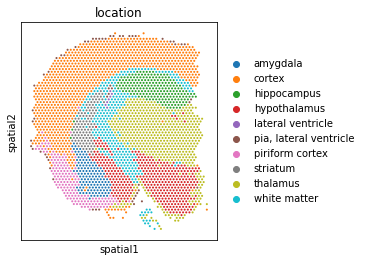

In [14]:
sc.pl.spatial(adata[adata.obs["sample"]=="ST8059048"],
                  library_id='spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna',
                  color=["location"], img_key=None
                )

In [16]:
# keep only hypothalamus regions
adata_hypo = adata[adata.obs["location"]=="hippocampus"]

In [17]:
adata.obs['subregion'].value_counts()

pan cortex                4295
dorsal                    2445
select thalamic nuclei    2115
ventral                   1422
lateral cortex (SS)        656
basomedial                 641
L1                         618
caudate putamen            561
habenula                   508
L2-3                       464
posterior                  179
CA2, CA3                   169
dentate gyrus              163
CA1                        148
Name: subregion, dtype: int64

In [21]:
adata.obs['location'].value_counts()

cortex                    4951
thalamus                  2623
hypothalamus              1866
white matter              1519
piriform cortex           1082
hippocampus               1064
amygdala                   820
striatum                   561
pia, lateral ventricle     363
lateral ventricle          119
Name: location, dtype: int64

In [22]:
adata_hypo.obs['subregion'].value_counts()

CA2, CA3         169
dentate gyrus    163
CA1              148
Name: subregion, dtype: int64

In [23]:
adata_hypo.obs['sample'].value_counts()

ST8059050    329
ST8059049    267
ST8059048    216
ST8059052    149
ST8059051    103
Name: sample, dtype: int64

In [24]:
adata_hypo.obs['comments'].value_counts().to_frame()

,comments
"stronger in CA1, CA2, CA3 but also observed in DG",584


In [25]:
adata_ori = adata.copy()
adata = adata_hypo
adata

View of AnnData object with n_obs × n_vars = 1064 × 31040
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample_name', 'sample_name2', 'image_name', 'slide', 'position', 'region_04092020', 'region_final', 'new_regions', 'old_region', 'location', 'subregion', 'cortical_layer', 'region_label', 'comments', 'observed_select_sections'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-ST8059048', 'mean_counts-ST8059048', 'log1p_mean_counts-ST8059048', 'pct_dropout_by_counts-ST8059048', 'total_counts-ST8059048', 'log1p_total_counts-ST8059048', 'n_cells_by_counts-ST8059049', 'mean_counts-ST8059049', 'log1p_mean_counts-ST8059049', 'pct_dropout_by_counts-ST8059049', 'total_counts-ST8059049', 'log1p_total_counts-ST8059049', 'n_cells_by_counts-ST805

### Look at QC metrics

Now let's look at QC: total number of counts and total number of genes per location across Visium experiments.

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


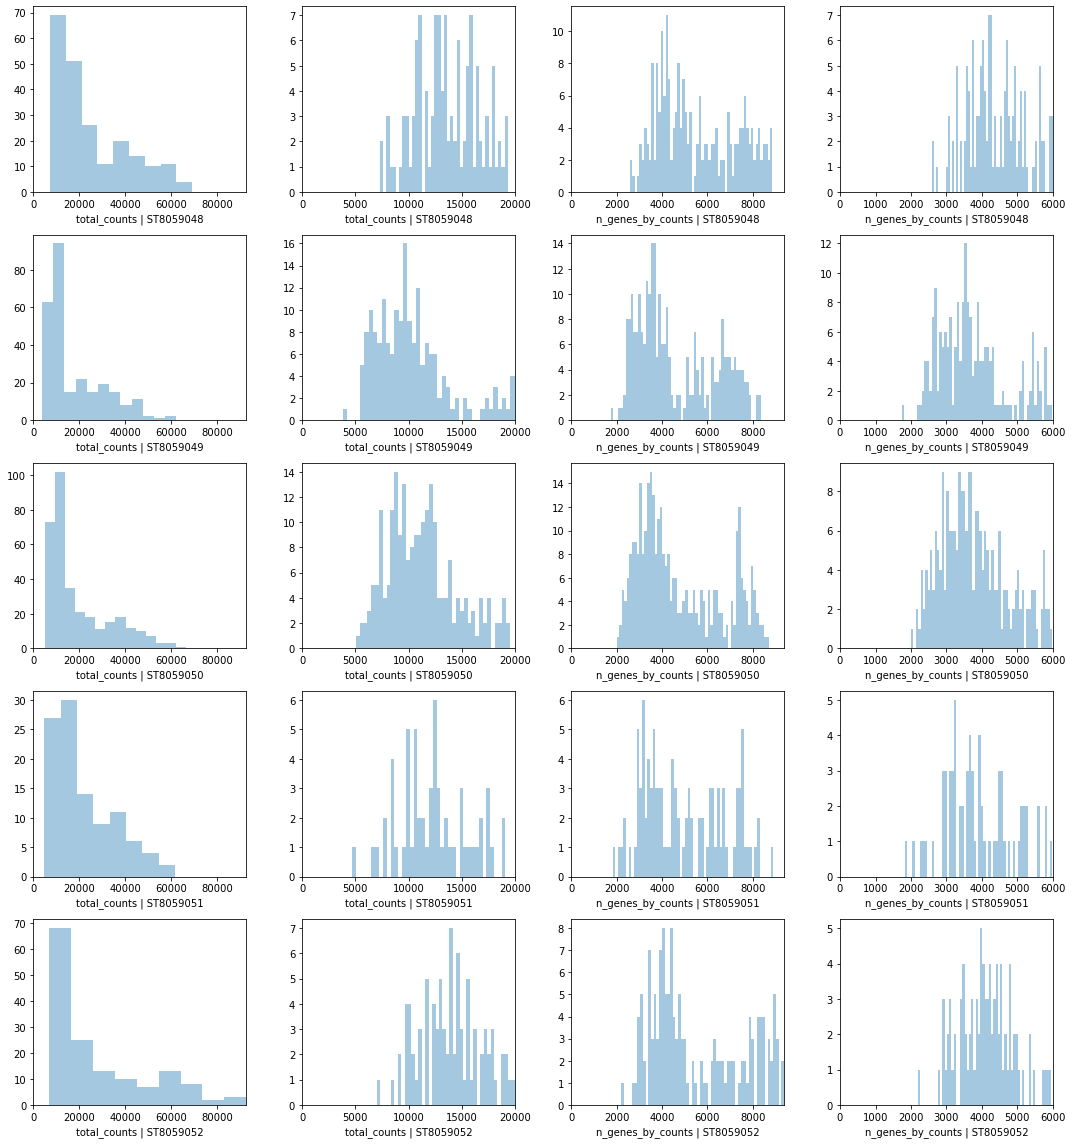

In [26]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')
    
    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')
    
    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')
    
    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')
    
    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')
    
plt.tight_layout()

## 2. Visualise Visium data in spatial 2D and UMAP coordinates <a name="2.-Visualise-Visium-data-in-spatial-2D-and-UMAP-coordinates"></a>

### Visualising data in spatial coordinates with scanpy

Next, we show how to plot these QC values over the histology image using standard scanpy tools

Trying to set attribute `.uns` of view, copying.
... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


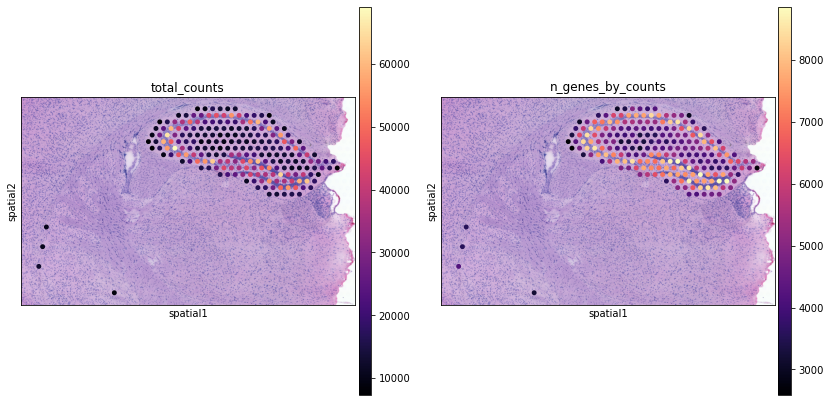

In [27]:
slide = select_slide(adata, 'ST8059048')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma', 
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

Here we show how to use scanpy to plot the expression of individual genes without the histology image.

In [ ]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide, 
                  color=["Meis2", "Pomc"], img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

Add counts matrix as `adata.raw` 

In [44]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [45]:
adata_vis.obs

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,region_04092020,region_final,new_regions,old_region,location,subregion,cortical_layer,region_label,comments,observed_select_sections
spot_id,,,,,,,,,,,,,,,,,,,,,
ST8059048_AAAGGGATGTAGCAAG-1,1,24,62,ST8059048,6311,8.750208,27620.0,10.226332,21.929761,27.983345,...,23.0,23,22.0,25,hippocampus,"CA2, CA3",NaN,HPC_CA2/3,NaN,NaN
ST8059048_AAATTACCTATCGATG-1,1,26,94,ST8059048,4950,8.507345,16884.0,9.734181,33.351102,38.823738,...,11.0,11,8.0,11,hippocampus,NaN,NaN,HPC,"stronger in CA1, CA2, CA3 but also observed in DG",NaN
ST8059048_AACATATCAACTGGTG-1,1,27,99,ST8059048,5966,8.694000,24077.0,10.089054,26.755825,32.159322,...,26.0,26,28.0,21,hippocampus,CA1,NaN,HPC_CA1,NaN,NaN
ST8059048_AACCGAGCTTGGTCAT-1,1,24,70,ST8059048,4198,8.342602,14249.0,9.564512,34.900695,40.662503,...,11.0,11,8.0,11,hippocampus,NaN,NaN,HPC,"stronger in CA1, CA2, CA3 but also observed in DG",NaN
ST8059048_AACGATATGTCAACTG-1,1,24,76,ST8059048,4190,8.340695,13251.0,9.491903,34.269112,39.687571,...,11.0,11,8.0,11,hippocampus,NaN,NaN,HPC,"stronger in CA1, CA2, CA3 but also observed in DG",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST8059052_TTCGTTCAACGAAGTT-1,1,23,105,ST8059052,4774,8.471149,17286.0,9.757710,32.459794,38.140692,...,11.0,11,8.0,11,hippocampus,NaN,NaN,HPC,"stronger in CA1, CA2, CA3 but also observed in DG",NaN
ST8059052_TTCTGCTAGACTCCAA-1,1,28,106,ST8059052,8502,9.048174,60217.0,11.005727,19.220486,25.173954,...,24.0,24,25.0,23,hippocampus,dentate gyrus,NaN,HPC_DG,NaN,NaN
ST8059052_TTCTTGGAGTAATGAG-1,1,21,79,ST8059052,9294,9.137232,90298.0,11.410882,17.971605,24.051474,...,23.0,23,22.0,25,hippocampus,"CA2, CA3",NaN,HPC_CA2/3,NaN,NaN


### Select two Visium sections to speed up the analysis

Select two Visium sections, also called experiments / batches, to speed up the analysis, one from each biological replicate.

```python
s = ['ST8059048', 'ST8059052']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(s),:]
```

### Construct and examine UMAP of locations

Now we apply the standard scanpy processing pipeline to the spatial Visium data to show experiment to experiment variability in the data. Importatly, this workflow will show the extent of batch differences in your data (cell2location works on samples jointly, see below).

In this mouse brain dataset, only a few regions should be different between sections because we are using 2 samples from biological replicates sectioned at a slightly different location along the anterior-posterior axis in the mouse brain. We see general alighnment of locations from both experiments and some mismatches, but as you will see in the downstream analysis notebook most of the differences between experiments here come from batch effect, which cell2location can account for.

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


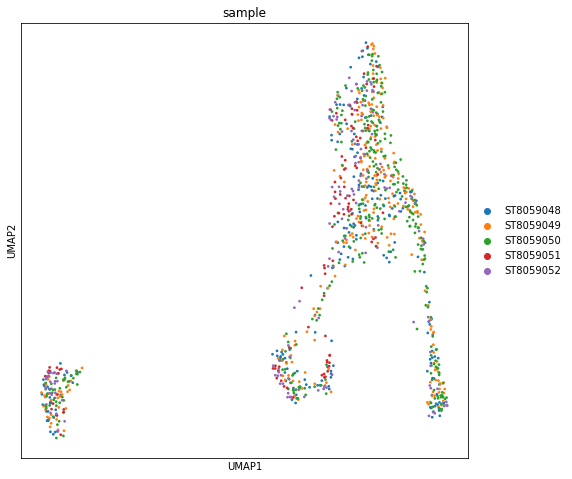

In [30]:
adata_vis_plt = adata_vis.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():
    
    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)
    
    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True
    
# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [8, 8],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

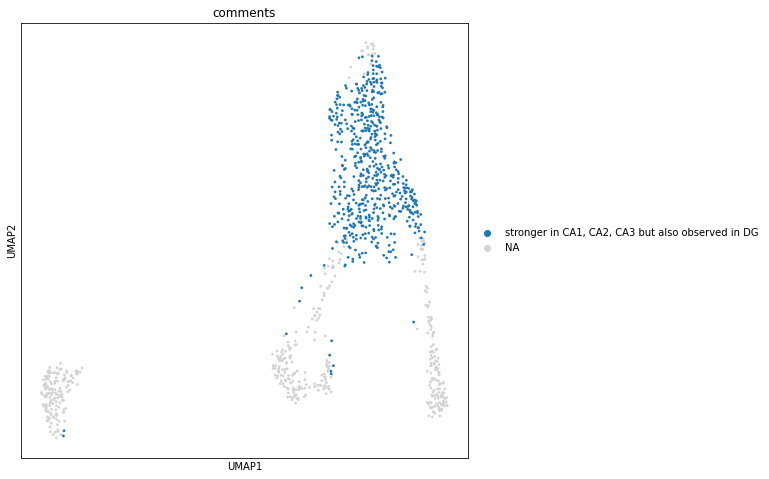

In [31]:
with mpl.rc_context({'figure.figsize': [8, 8],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['comments'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

In [46]:
reg_mod_name = 'RegressionGeneBackgroundCoverageTorch_54covariates_40064cells_14795genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [47]:
adata_snrna_raw.shape

(40064, 14795)

In [48]:
adata_snrna_raw.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,percent.mt,integrated_snn_res.1.5,seurat_clusters,group,major_group,n_genes
Unnamed: 0,,,,,,,,,,
CCAATCCTCGTTTATC-1_1,Aged_1,1018,762,Aged,0.785855,55,55,1700042O10Rik/Ddc,Neuron,762
CAGTCCTAGTCCATAC-1_1,Aged_1,4352,2203,Aged,0.620404,55,55,1700042O10Rik/Ddc,Neuron,2203
CATGGATGTTGCTGAT-1_4,Aged_4,32357,7259,Aged,0.154526,55,55,1700042O10Rik/Ddc,Neuron,7259
TCTTTCCTCTGCTGCT-1_2,Aged_2,4189,1921,Aged,1.169730,55,55,1700042O10Rik/Ddc,Neuron,1921
TCATGAGTCACGAACT-1_4,Aged_4,23950,5868,Aged,0.083507,55,55,1700042O10Rik/Ddc,Neuron,5868
...,...,...,...,...,...,...,...,...,...,...
TTCATGTAGTAAACTG-1_8,Young_4,3802,2010,Young,2.183062,50,50,VLMC,VLMC,2010
TTTGGTTGTGCGAAAC-1_6,Young_2,1692,1060,Young,1.063830,50,50,VLMC,VLMC,1060
TGCTGCTGTGCAACGA-1_1,Aged_1,1555,958,Aged,1.221865,50,50,VLMC,VLMC,958


In [50]:
# Column name containing cell type annotations
covariate_col_names = 'group'

# Extract a pd.DataFrame with signatures from anndata object
inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

Quick look at the cell type composition in our reference data in UMAP coordinates (UMAP representation was generated using a standard scanpy workflow, see notebook 1/3).

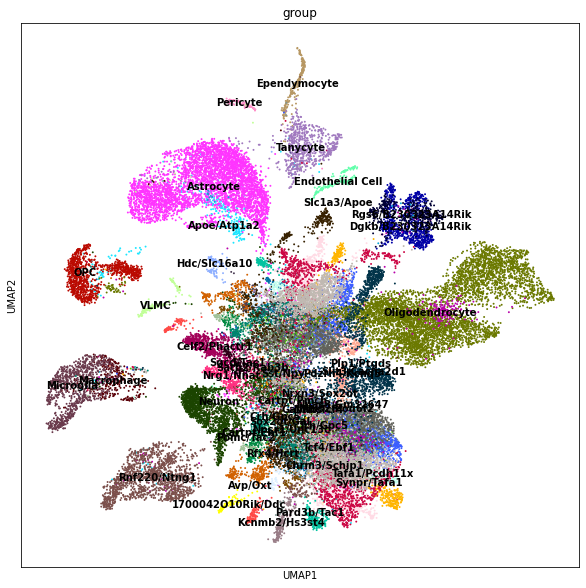

In [36]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['group'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

In [37]:
# now we don't need to keep the scRNA-seq data set and a list with slides in memory
del adata_snrna_raw, slides
gc.collect()

108073

### Training cell2location: specifying data input and hyper-parameters

Here we show how to train cell2location model to estimate cell abundances in each location. This workflow is wrapped into a single pipeline:

In [51]:
adata_vis.var = adata_vis.var.set_index('SYMBOL')

In [58]:
sc.settings.set_figure_params(dpi = 100, color_map = 'viridis', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(
    
      # Single cell reference signatures as pd.DataFrame 
      # (could also be data as anndata object for estimating signatures 
      #  as cluster average expression - `sc_data=adata_snrna_raw`)
      sc_data=inf_aver, 
      # Spatial data as anndata object
      sp_data=adata_vis,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "group",
                        },

      train_args={'use_raw': True, # By default uses raw slots in both of the input datasets.
                  'n_iter': 40000, # Increase the number of iterations if needed (see QC below)
                  
                  # Whe analysing the data that contains multiple experiments, 
                  # cell2location automatically enters the mode which pools information across experiments
                  'sample_name_col': 'sample'}, # Column in sp_data.obs with experiment ID (see above)

    
      export_args={'path': results_folder, # path where to save results
                   'run_name_suffix': '' # optinal suffix to modify the name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located groups
          
                    'cell_number_prior': {
                        # - N - the expected number of cells per location:
                        'cells_per_spot': 8, # < - change this
                        # - A - the expected number of cell types per location (use default):
                        'factors_per_spot': 7, 
                        # - Y - the expected number of co-located cell type groups per location (use default):
                        'combs_per_spot': 7
                    },
          
                     # Prior beliefs on the sensitivity of spatial technology:
                    'gene_level_prior':{
                        # Prior on the mean
                        'mean': 1/2, 
                        # Prior on standard deviation,
                        # a good choice of this value should be at least 2 times lower that the mean
                        'sd': 1/4
                    }
      }
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Summarising single cell clusters ###
### Creating model ### - time 0.0 min
### Analysis name: LocationModelLinearDependentWMultiExperiment_5experiments_46clusters_1064locations_14142genes
### Training model ###


Finished [100%]: Average Loss = 1.2475e+07


Finished [100%]: Average Loss = 1.2475e+07


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

### Sampling posterior ### - time 35.87 min


  0%|          | 0/24 [00:00<?, ?it/s]

### Saving results ###


... storing 'sample' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'location' as categorical
... storing 'region_label' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


### Ploting results ###
### Plotting posterior of W / cell locations ###
### Done ### - time 45.32 min


### Cell2location model output

In [59]:
results_folder + r['run_name']

'./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_5experiments_46clusters_1064locations_14142genes'

In [60]:
results_folder +r['run_name']+'/plots/training_history_without_first_20perc.png'

'./results/mouse_brain_snrna/LocationModelLinearDependentWMultiExperiment_5experiments_46clusters_1064locations_14142genes/plots/training_history_without_first_20perc.png'

The absolute abundances of cell types are added to `sp_data` as columns of `sp_data.obs`. The estimates of all parameters in the model are exported to `sp_data.uns['mod']`. 

#### List of output files:

- **sp.h5ad** - Anndata object with all results and spatial data.   
- W_cell_density.csv - *absolute abundances of cell types*, mean of the posterior distribution.   
- ***(default)*** - W_cell_density_q05.csv - *absolute abundances of cell types*, 5% quantile of the posterior distribution representing confident cell abundance level.   
- W_mRNA_count.csv - *absolute mRNA abundance* for each cell types, mean of the posterior distribution.
- ***(useful for QC, selecting mapped cell types)*** - W_mRNA_count_q05.csv - *absolute mRNA abundance* for each cell types, 5% quantile of the posterior distribution representing confident cell abundance level.   

The same 4 estimates are also plotted for each cell type (saved to `r['run_name']/plots/scanpy`, on black background and overlayed on the histology image paired with each sample (saved with `histo_` prefix).


The downstream analysis notebook adds more results and creates the file:
- sp_with_clusters.h5ad

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

In [61]:
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_5experiments_46clusters_1064locations_14142genes'}

### Evaluating training <a name="Evaluating-training"></a>

Now we need to check if our model has trained successfully by examining a few diagnosic plots. 

First, we look at the ELBO loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by many orders of magnitude. Here we see that the model converged by the end of training, some noise in the ELBO loss function is acceptable. If there are large changes during the last few thousands of iterations we recommend increasing the `'n_iter'` parameter. 

Divergence in ELBO loss between training iterations indicates the problem with training which can be caused by incomplete or insufficiently detailed reference of cell types.

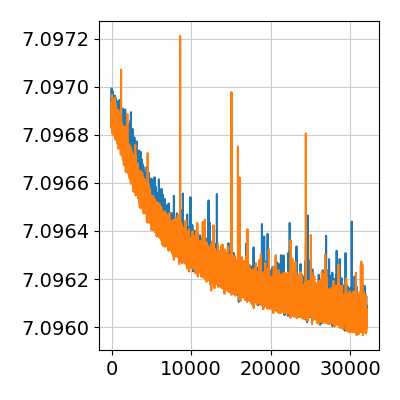

In [62]:
from IPython.display import Image
Image(filename=results_folder +r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy: how well reference cell type signatures explain spatial data by comparing expected value of the model $\mu_{s,g}$ (Negative Binomial mean) to observed count of each gene across locations. The ideal case is a perfect diagonal 2D histogram plot (across genes and locations). 

A very fuzzy diagonal or large deviations of some genes and locations from the diagonal plot indicate that the reference signatures are incomplete. The reference could be missing certain cell types entirely (e.g. FACS-sorting one cell lineage) or clustering could be not sufficiently granular (e.g. mapping 5-10 broad cell types to a complex tissue). Below is an example of good performance:

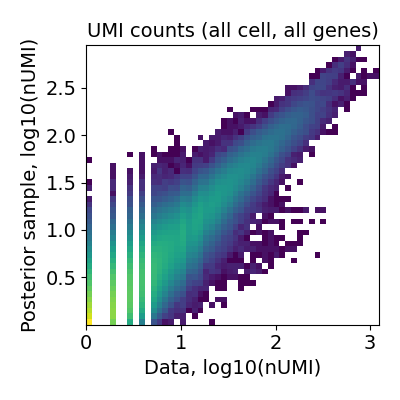

In [63]:
Image(filename=results_folder +r['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of estimated cell abundances between two independent training restarts (X- and Y-axis). The plot below shows the correlation (color) between cell abundance profiles in 2 training restarts. Some cell types can be correlated, but excessive deviations from diagonal would indicate instability of the solution (we have not seen this so far).

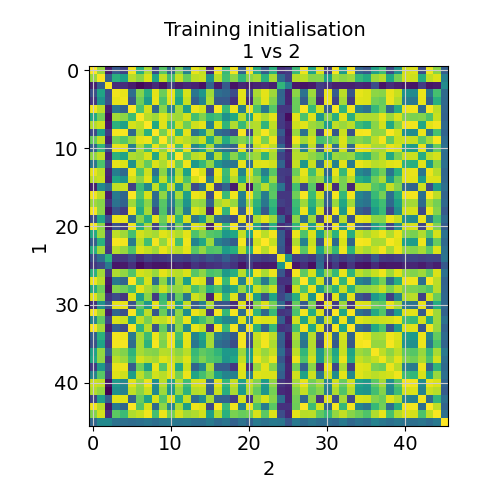

In [64]:
Image(filename=results_folder +r['run_name']+'/plots/evaluate_stability.png',
      width=400)

Modules and their versions used for this analysis

In [45]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
ipykernel 6.0.3
ipykernel._version 6.0.3
json 2.0.9
re 2.2.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
zlib 1.0
platform 1.0.8
jupyter_client 6.1.12
jupyter_client._version 6.1.12
zmq 22.1.0
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40304
zmq.backend.cython.constants 40304
zmq.sugar 22.1.0
zmq.sugar.constants 40304
zmq.sugar.version 22.1.0
traitlets 5.0.5
traitlets._version 5.0.5
logging 0.5.1.2
argparse 1.1
jupyter_core 4.7.1
jupyter_core.version 4.7.1
tornado 6.1
colorama 0.4.4
_curses b'2.2'
IPython 7.25.0
IPython.core.release 7.25.0
IPython.core.crashhandler 7.25.0
pygments 2.9.0
pexpect 4.8.0
ptyprocess 0.7.0
decorator 5.0.9
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.19
wcwidth 0.2.5
jedi 0.18.0
parso 0.8.2
IPython.core.magics.code 7.25.0
urllib.request 3.7
dateutil 2.8.2
dateutil._version 2.8.2
six 1.16.0
decimal 1.70
_de